In [2]:
# Download data
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'andrewmvd/medical-mnist'
!unzip -q medical-mnist.zip -d data
!rm medical-mnist.zip

Saving kaggle.json to kaggle.json
 99% 84.0M/84.8M [00:00<00:00, 97.3MB/s]
100% 84.8M/84.8M [00:00<00:00, 109MB/s] 


In [3]:
# Installations
!pip install pytorch-lightning
# !pip install torchvision

     |████████████████████████████████| 525 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 34.3 MB/s 
     |████████████████████████████████| 829 kB 44.3 MB/s 
     |████████████████████████████████| 132 kB 46.8 MB/s 
     |████████████████████████████████| 332 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 29.8 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
     |████████████████████████████████| 160 kB 49.2 MB/s 
     |████████████████████████████████| 192 kB 45.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=54c5e393bc5794e08950e236babc70e0702418d66977c47a1a3560358cbf5291
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [4]:
# Imports
import os
from torchvision.datasets import ImageFolder
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from pytorch_lightning.core.lightning import LightningModule

In [5]:
# Data preparation

class MedicalDataMNIST(pl.LightningDataModule):
    def __init__(self, num_workers=1):
      super().__init__()
      self.num_workers = num_workers
      self.labels_map = {0 : "AbdomenCT",
                         1 : "BreastMRI",
                         2 : "CXR",
                         3 : "ChestCT",
                         4 : "Hand",
                         5 : "HeadCT"}
      self.transform = transforms.Compose([transforms.Resize((633, 600)), # EfficientNet_B7 input size
                                           transforms.ColorJitter(hue=.20, saturation=.20),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(10),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])
      # self.train_dims = None
      # self.vocab_size = 0

    def prepare_data(self):
      # called only on 1 GPU
      self.dataset = ImageFolder("./data/", transform=self.transform)

    def setup(self):
      # called on every GPU
      # vocab = load_vocab()
      # self.vocab_size = len(vocab)
      test_size = int(0.1 * len(self.dataset))
      self.test_set = torch.utils.data.Subset(self.dataset, range(test_size))  # take 10% for test
      self.train_set = torch.utils.data.Subset(self.dataset, range(test_size, len(self.dataset))) # the last part for train
      val_size = int(0.2 * len(self.train_set))
      train_size = len(self.train_set) - val_size
      self.train_set, self.val_set = torch.utils.data.random_split(self.train_set,
                                                                  [train_size, val_size])

    def train_dataloader(self):
      return DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
      return DataLoader(self.val_set, batch_size=64, shuffle=True, num_workers=self.num_workers)

    def test_dataloader(self):
      return DataLoader(self.test_set, batch_size=64, shuffle=True, num_workers=self.num_workers)

    def visualize_dataset(self):
      # Visualizes dataset
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, cols * rows + 1):
          sample_idx = torch.randint(len(self.train_set), size=(1,)).item()
          img, label = self.train_set[sample_idx]
          figure.add_subplot(rows, cols, i)
          plt.title(self.labels_map[label])
          plt.axis("off")
          plt.imshow(img.permute(1, 2, 0))
      plt.show()

    def visualize_dataloader(self):
      # Display image and label
      train_dataloader = self.train_dataloader()
      train_features, train_labels = next(iter(train_dataloader))
      print(f"Feature batch shape: {train_features.size()}")
      print(f"Labels batch shape: {train_labels.size()}")
      img = train_features[0]
      label = train_labels[0]
      plt.imshow(img.permute(1, 2, 0))
      plt.show()
      print(f"Label: {self.labels_map[label.item()]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


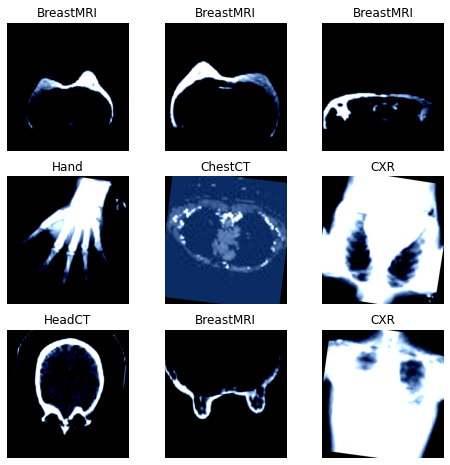

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 633, 600])
Labels batch shape: torch.Size([64])


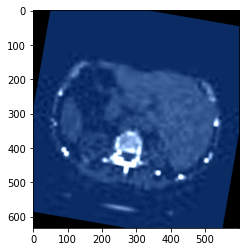

Label: ChestCT


In [6]:
dm = MedicalDataMNIST()
dm.prepare_data()
dm.setup()
dm.visualize_dataset()
dm.visualize_dataloader()

In [7]:
# Creating model

class MedicalMNIST(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b7(pretrained=True, num_classes = 6)
        # num_ftrs = self.model.fc.in_features
        # self.model.fc = torch.nn.Linear(num_ftrs, 6)
        
        
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.nll_loss(logits, y)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [8]:
# MAIN
# Number of cpus and gpus
NUM_DATALOADER_WORKERS = os.cpu_count()
print(f"Number of cpus: {NUM_DATALOADER_WORKERS}")
NUM_GPUS = torch.cuda.device_count() if torch.cuda.is_available() else None
print(f"Number of gpus: {NUM_GPUS}")

# Train
medical_mnist_data = MedicalDataMNIST(num_workers=NUM_DATALOADER_WORKERS)
model = MedicalMNIST()
trainer = Trainer(gpus=NUM_GPUS)
trainer.fit(model, medical_mnist_data)

Number of cpus: 2
Number of gpus: 1


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

RuntimeError: ignored